# 군집에 영향을 미치는 변수들의 가중치 구하기

이해원

**[조건]**

인코딩ok, 업권(손해/생명/신협) 분리, 코사인 유사도 클러스터링

</br>

**[진행한 내용]**

**1. RF를 이용한 Feature Importance 시각화 확인**

- 각 컬럼의 중요도를 0~1사이로 나타낸 시각화 결과를 살펴봤습니다.

- 중요도는 해당 피쳐의 가중치가 아니라, 그냥 피쳐 간 상대적인 중요도입니다.

</br>

**2. 모든 업권에서, 중요도 순위는 *mean_AMT > CT_PY_PD > AGE_GROUP* 순**

- *AGE_GROUP*의 경우, 처음에는 그냥 무시하고 이후 작업 진행했었는데요. 혹시 몰라서 넣고 돌려보니 꽤 그럴듯한 결과가 나오길래 추가했습니다.

</br>

**3. 다중로지스틱회귀를 이용하여, 각 피쳐들의 가중치 계산**

- 제일 아래로 스크롤 쫙 내리시면 [정리] 부분이에요. 괄호 안의 0.nnnn은 정확도입니다.

</br>

**4. 다중로지스틱회귀 사용 이유**

- 범주형 변수를 다루는 측면에서:

  - 다중 로지스틱 회귀는 다중 클래스 분류 문제를 해결하는 데 사용되는 모델이지만, 데이터셋에 많은 수의 범주형 변수와 각 변수에 다수의 범주가 있는 경우에도 유용하게 적용될 수 있다고 합니다.
  
  - 자동으로 더미 변수화(dummy encoding)된 형태로 범주형 변수를 처리하여 모델에 포함시킴으로써 범주형 변수를 직접 처리할 수 있습니다.

- 피쳐 선택 및 해석 측면에서:

  - 모델의 계수를 통해 각 피처가 클래스를 예측하는 데 얼마나 중요한지를 해석할 수 있습니다.
  
  - 데이터셋에 많은 수의 피처가 있더라도 유용한 피처를 선택하고 해석할 수 있습니다.

- 기타:

  - 코사인으로 군집화한 결과가 우리가 선택한 변수(*mean_AMT, CT_PY_PD*)에 대해 선형이 아니기 때문에 선형회귀는 X
  
  - 이외에도 군집에 영향을 미친 피쳐들의 가중치를 구하는 굉장히 여러가지+어려운 방법이 있었는데, 굳이 어려운 방법을 안 해도 다중~으로도 충분히 잘 풀린 것 같습니다.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
pd.set_option('display.max_columns', None)
fin = pd.read_csv('final_enco_업권분류.csv')

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1. 총지급 건수 ==  0

In [4]:
fin_only0 = fin[fin['총지급 건수'] == 0]

## 드랍 컬럼

In [5]:
drop_col = ['JOIN_SN', 'POL_SN', 'CT_CHNL_CD',
            'reduce_GBN_CD', 'reduce_STAT_CD', 'CT_CHNL_CD',
            'CT_PY_AMT', '총지급금액', '총지급 건수',
            '연령대_0', '연령대_1', '연령대_2', '연령대_3', '연령대_4', '연령대_5', '연령대_6',
            '연령대_7', '연령대_8', '기타', '배책', '사망/후유', '수술/입원', '실손', '자동차', '진단/통원', '화재/재물',
            '채널_1', '채널_2', '채널_3', '채널_4', '채널_5', '채널_6', '채널_7', '채널_99',
            '성별_1', '성별_2']

fin_only0 = fin_only0.drop(columns=drop_col)
fin_only0.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,업권
0,2,2,1,0,5000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,2
1,2,2,2,5,170.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2
2,2,4,2,3,180.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
3,1,4,1,0,110.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
4,1,5,2,20,50.0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


## 업권 확인

- 0: 신협
- 1: 손해보험
- 2: 생명보험

In [6]:
fin_only0['업권'].value_counts()

업권
1    28233
2    20341
0     3623
Name: count, dtype: int64

# 2. 손해보험 = 1 (28233건)

In [7]:
fin_only0_1 = fin_only0[fin_only0['업권'] == 1].reset_index(drop=True)
fin_only0_1.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,업권
0,1,4,1,0,110.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1
1,1,6,2,10,15.0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
2,1,2,2,20,140.0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
3,1,5,1,0,280.0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
4,2,5,2,20,88.0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [8]:
fin_only0_1 = fin_only0_1.drop(columns='업권')

### KMeans (5개)

In [9]:
k = 5
kmeans_only0_1 = KMeans(n_clusters=k, random_state=42)
kmeans_only0_1.fit(fin_only0_1)

fin_only0_1['군집'] = kmeans_only0_1.labels_
fin_only0_1.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,군집
0,1,4,1,0,110.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,4
1,1,6,2,10,15.0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,4
2,1,2,2,20,140.0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4
3,1,5,1,0,280.0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,4
4,2,5,2,20,88.0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4


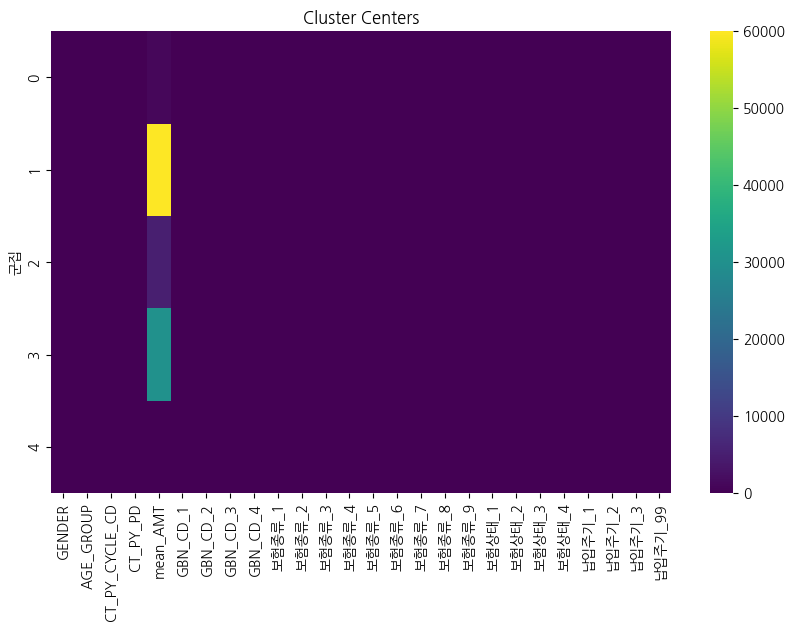

In [10]:
cluster_centers = fin_only0_1.groupby('군집').mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers, cmap='viridis')
plt.title('Cluster Centers')
plt.show()

### 코사인 거리

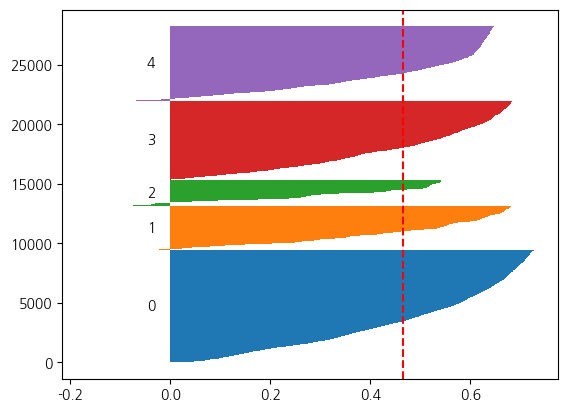

In [11]:
cosine_sim_only0_1 = cosine_similarity(fin_only0_1)

k=5

fig, ax = plt.subplots(1, 1)
kmeans_0_1 = KMeans(n_clusters=k, random_state=42).fit(cosine_sim_only0_1)
silhouette_vals = silhouette_samples(cosine_sim_only0_1, kmeans_0_1.labels_)
y_ticks = []
y_lower = y_upper = 0

for c_num in np.unique(kmeans_0_1.labels_):
    cluster_silhouette_vals = silhouette_vals[kmeans_0_1.labels_==c_num]
    y_upper += len(cluster_silhouette_vals)
    cluster_silhouette_vals.sort()

    ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    ax.text(-0.03, (y_lower + y_upper) / 2, str(c_num), ha='right', va='center')
    y_lower += len(cluster_silhouette_vals)
    
ax.axvline(np.mean(silhouette_vals), color="red", linestyle="--")

In [12]:
fin_only0_1.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,군집
0,1,4,1,0,110.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,4
1,1,6,2,10,15.0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,4
2,1,2,2,20,140.0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4
3,1,5,1,0,280.0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,4
4,2,5,2,20,88.0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4


In [13]:
fin_only0_1['코사인군집'] = kmeans_0_1.labels_
fin_0_1 = fin_only0_1.drop(columns='군집')
fin_0_1.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,코사인군집
0,1,4,1,0,110.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,4
1,1,6,2,10,15.0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,3
2,1,2,2,20,140.0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4
3,1,5,1,0,280.0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,4
4,2,5,2,20,88.0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [43]:
fin_0_1['코사인군집'].value_counts()

코사인군집
0    9486
3    6720
4    6221
1    3664
2    2142
Name: count, dtype: int64

In [44]:
# fin_0_1.to_csv('cosine_cluster_손해보험.csv', index=False)

## RF - feature importance

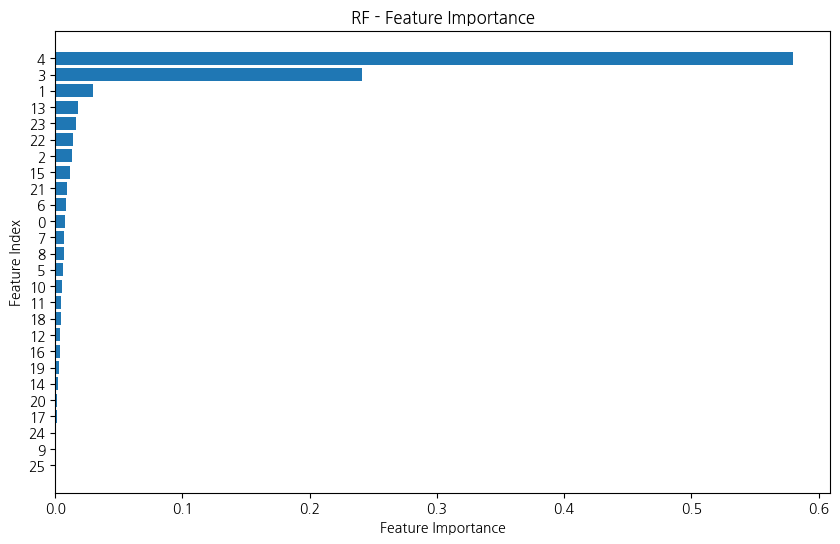

In [15]:
model_rf = RandomForestClassifier()

X_features = ['GENDER', 'AGE_GROUP', 'CT_PY_CYCLE_CD', 'CT_PY_PD', 'mean_AMT',
              'GBN_CD_1', 'GBN_CD_2', 'GBN_CD_3', 'GBN_CD_4', '보험종류_1', '보험종류_2',
              '보험종류_3', '보험종류_4', '보험종류_5', '보험종류_6', '보험종류_7', '보험종류_8', '보험종류_9',
              '보험상태_1', '보험상태_2', '보험상태_3', '보험상태_4', '납입주기_1', '납입주기_2', '납입주기_3',
              '납입주기_99']

x = fin_0_1[X_features]
y = fin_0_1['코사인군집']

model_rf.fit(x, y)

# 특성 중요도 추출
feature_importance = model_rf.feature_importances_
sorted_idx = np.argsort(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(range(x.shape[1]))[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('RF - Feature Importance')
plt.show()

## 다중 로지스틱회귀

### (1) 분리X

In [16]:
X = fin_0_1[['mean_AMT', 'CT_PY_PD']]
y = fin_0_1['코사인군집']

model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_logistic.fit(X, y)

acc_X = model_logistic.score(X, y)

# 학습된 모델의 계수 확인
lor_coef = model_logistic.coef_[0]
lor_intercept = model_logistic.intercept_

# 변수 지정
w1_lor = lor_coef[0].round(2)
w2_lor = lor_coef[1].round(2)
bias_lor = lor_intercept[0].round(2)

print(w1_lor, w2_lor, bias_lor)
print("mean_AMT *", w1_lor, "+", "CT_PY_PD *", w2_lor, "+", bias_lor)
print("정확도:", acc_X)

1.51 -1.3 -5.18
mean_AMT * 1.51 + CT_PY_PD * -1.3 + -5.18
정확도: 0.9655013636524634


C:\Users\LOVE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### (2) AGE_GROUP도 포함

In [18]:
X = fin_0_1[['mean_AMT', 'CT_PY_PD', 'AGE_GROUP']]
y = fin_0_1['코사인군집']

model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_logistic.fit(X, y)

acc_X = model_logistic.score(X, y)

# 학습된 모델의 계수 확인
lor_coef = model_logistic.coef_[0]
lor_intercept = model_logistic.intercept_

# 변수 지정
w1_lor = lor_coef[0].round(2)
w2_lor = lor_coef[1].round(2)
w3_lor = lor_coef[2].round(2)
bias_lor = lor_intercept[0].round(2)

print(w1_lor, w2_lor, w3_lor, bias_lor)
print("mean_AMT *", w1_lor, "+", "CT_PY_PD *", w2_lor, "+", "AGE_GROUP *", w3_lor, "+", bias_lor)
print("정확도:", acc_X)

1.57 -1.91 -0.77 -1.16
mean_AMT * 1.57 + CT_PY_PD * -1.91 + AGE_GROUP * -0.77 + -1.16
정확도: 0.969574611270499


C:\Users\LOVE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 2. 생명보험 = 2 (20341건)

In [20]:
fin_only0 = fin[fin['총지급 건수'] == 0]
fin_only0_2 = fin_only0[fin_only0['업권'] == 2].reset_index(drop=True)
fin_only0_2 = fin_only0_2.drop(columns='업권')
fin_only0_2 = fin_only0_2.drop(columns=drop_col)
fin_only0_2.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99
0,2,2,1,0,5000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
1,2,2,2,5,170.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,1,4,2,10,18.0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,1,7,2,10,17.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,1,5,2,20,1300.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### KMeans (5개)

In [21]:
k = 5
kmeans_only0_2 = KMeans(n_clusters=k, random_state=42)
kmeans_only0_2.fit(fin_only0_2)

fin_only0_2['군집'] = kmeans_only0_2.labels_
fin_only0_2.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,군집
0,2,2,1,0,5000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,2,2,2,5,170.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,1,4,2,10,18.0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4
3,1,7,2,10,17.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4
4,1,5,2,20,1300.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3


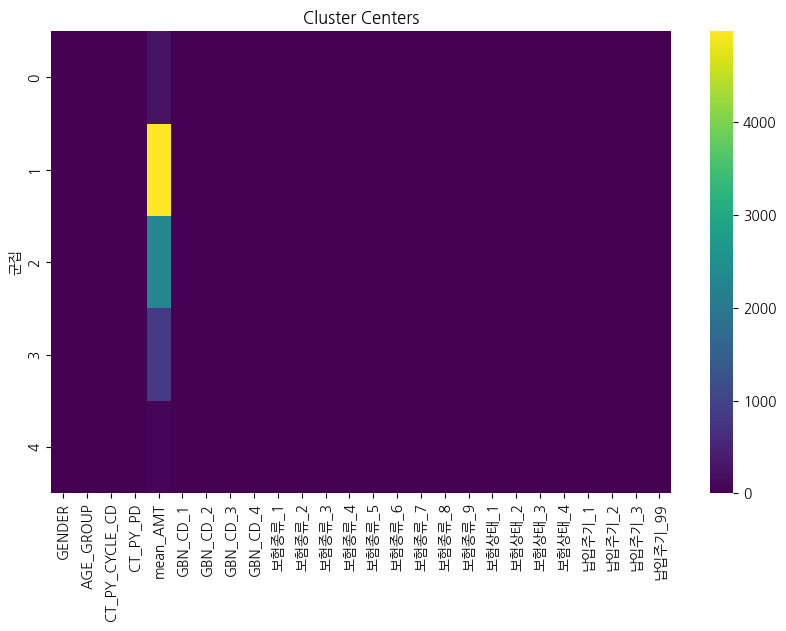

In [22]:
cluster_centers = fin_only0_2.groupby('군집').mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers, cmap='viridis')
plt.title('Cluster Centers')
plt.show()

### 코사인 거리

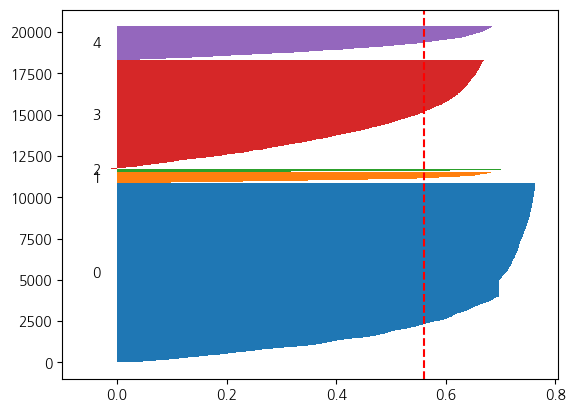

In [23]:
cosine_sim_only0_2 = cosine_similarity(fin_only0_2)

k=5

fig, ax = plt.subplots(1, 1)
kmeans_0_2 = KMeans(n_clusters=k, random_state=42).fit(cosine_sim_only0_2)
silhouette_vals = silhouette_samples(cosine_sim_only0_2, kmeans_0_2.labels_)
y_ticks = []
y_lower = y_upper = 0

for c_num in np.unique(kmeans_0_2.labels_):
    cluster_silhouette_vals = silhouette_vals[kmeans_0_2.labels_==c_num]
    y_upper += len(cluster_silhouette_vals)
    cluster_silhouette_vals.sort()

    ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    ax.text(-0.03, (y_lower + y_upper) / 2, str(c_num), ha='right', va='center')
    y_lower += len(cluster_silhouette_vals)
    
ax.axvline(np.mean(silhouette_vals), color="red", linestyle="--")

In [24]:
fin_only0_2['코사인군집'] = kmeans_0_2.labels_
fin_0_2 = fin_only0_2.drop(columns='군집')
fin_0_2.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,코사인군집
0,2,2,1,0,5000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
1,2,2,2,5,170.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,1,4,2,10,18.0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4
3,1,7,2,10,17.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4
4,1,5,2,20,1300.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [25]:
fin_0_2['코사인군집'].value_counts()

코사인군집
0    10842
3     6574
4     2056
1      681
2      188
Name: count, dtype: int64

In [42]:
# fin_0_2.to_csv('cosine_cluster_생명보험.csv', index=False)

## RF - feature importance

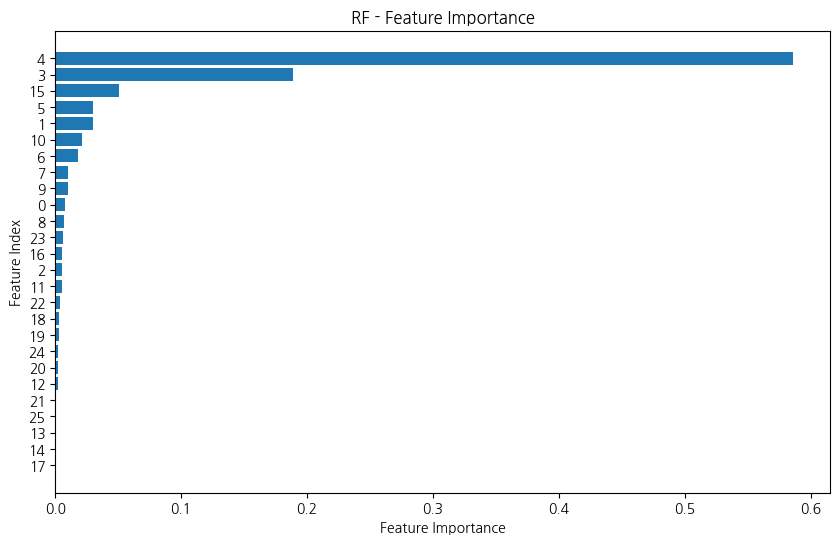

In [26]:
model_rf02 = RandomForestClassifier()

X_features = ['GENDER', 'AGE_GROUP', 'CT_PY_CYCLE_CD', 'CT_PY_PD', 'mean_AMT',
              'GBN_CD_1', 'GBN_CD_2', 'GBN_CD_3', 'GBN_CD_4', '보험종류_1', '보험종류_2',
              '보험종류_3', '보험종류_4', '보험종류_5', '보험종류_6', '보험종류_7', '보험종류_8', '보험종류_9',
              '보험상태_1', '보험상태_2', '보험상태_3', '보험상태_4', '납입주기_1', '납입주기_2', '납입주기_3',
              '납입주기_99']

x = fin_0_2[X_features]
y = fin_0_2['코사인군집']

model_rf02.fit(x, y)

# 특성 중요도 추출
feature_importance = model_rf02.feature_importances_
sorted_idx = np.argsort(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(range(x.shape[1]))[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('RF - Feature Importance')
plt.show()

## 다중 로지스틱회귀

### (1) 분리X

In [27]:
X = fin_0_2[['mean_AMT', 'CT_PY_PD']]
y = fin_0_2['코사인군집']

logi2 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logi2.fit(X, y)

acc_X = logi2.score(X, y)

# 학습된 모델의 계수 확인
lor_coef = logi2.coef_[0]
lor_intercept = logi2.intercept_

# 변수 지정
w1_lor = lor_coef[0].round(2)
w2_lor = lor_coef[1].round(2)
bias_lor = lor_intercept[0].round(2)

print(w1_lor, w2_lor, bias_lor)
print("mean_AMT *", w1_lor, "+", "CT_PY_PD *", w2_lor, "+", bias_lor)
print("정확도:", acc_X)

1.45 -3.14 -8.23
mean_AMT * 1.45 + CT_PY_PD * -3.14 + -8.23
정확도: 0.9706504105009587


C:\Users\LOVE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### (2) AGE_GROUP도 포함

In [29]:
X = fin_0_2[['mean_AMT', 'CT_PY_PD', 'AGE_GROUP']]
y = fin_0_2['코사인군집']

logi2 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logi2.fit(X, y)

acc_X = logi2.score(X, y)

# 학습된 모델의 계수 확인
lor_coef = logi2.coef_[0]
lor_intercept = logi2.intercept_

# 변수 지정
w1_lor = lor_coef[0].round(2)
w2_lor = lor_coef[1].round(2)
w3_lor = lor_coef[2].round(2)
bias_lor = lor_intercept[0].round(2)

print(w1_lor, w2_lor, w2_lor, bias_lor)
print("mean_AMT *", w1_lor, "+", "CT_PY_PD *", w2_lor, "+", "AGE_GROUP *", w3_lor, "+", bias_lor)
print("정확도:", acc_X)

1.78 -3.85 -3.85 -2.02
mean_AMT * 1.78 + CT_PY_PD * -3.85 + AGE_GROUP * -1.42 + -2.02
정확도: 0.986283860183865


C:\Users\LOVE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 3. 신협 = 0 (3623건)

In [30]:
fin_only0 = fin[fin['총지급 건수'] == 0]
fin_only0_0 = fin_only0[fin_only0['업권'] == 0].reset_index(drop=True)
fin_only0_0 = fin_only0_0.drop(columns='업권')
fin_only0_0 = fin_only0_0.drop(columns=drop_col)

fin_only0_0.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99
0,2,4,2,3,180.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1,1,5,2,20,50.0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,2,6,2,10,440.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3,2,3,2,20,15.0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,2,3,2,15,37.0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### KMeans (5개)

In [31]:
k = 5
kmeans_only0_0 = KMeans(n_clusters=k, random_state=42)
kmeans_only0_0.fit(fin_only0_0)

fin_only0_0['군집'] = kmeans_only0_0.labels_
fin_only0_0.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,군집
0,2,4,2,3,180.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
1,1,5,2,20,50.0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,2,6,2,10,440.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,3
3,2,3,2,20,15.0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,2,3,2,15,37.0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


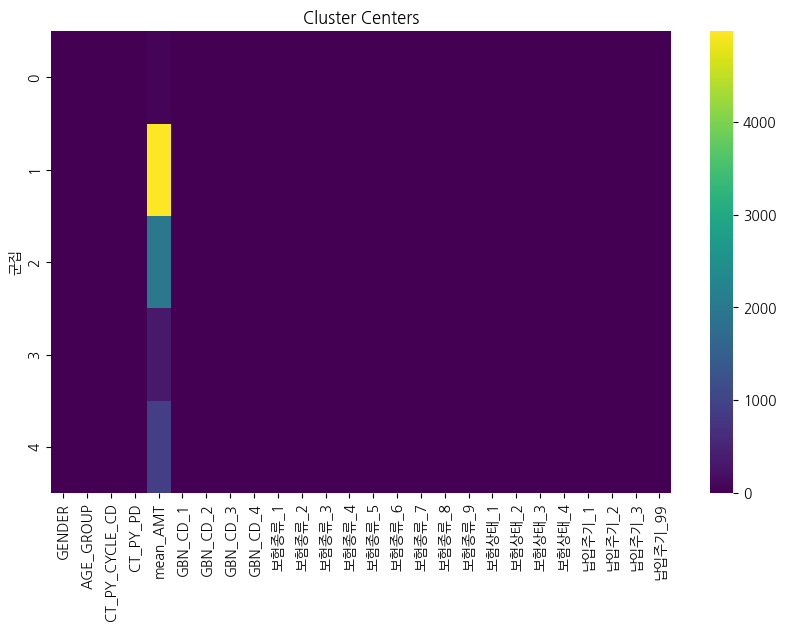

In [32]:
cluster_centers = fin_only0_0.groupby('군집').mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers, cmap='viridis')
plt.title('Cluster Centers')
plt.show()

### 코사인 거리

In [33]:
cosine_sim_only0_0 = cosine_similarity(fin_only0_0)

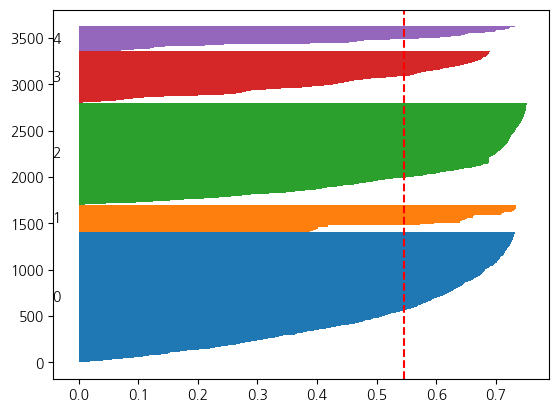

In [34]:
k=5

fig, ax = plt.subplots(1, 1)
kmeans_0_0 = KMeans(n_clusters=k, random_state=42).fit(cosine_sim_only0_0)
silhouette_vals = silhouette_samples(cosine_sim_only0_0, kmeans_0_0.labels_)
y_ticks = []
y_lower = y_upper = 0

for c_num in np.unique(kmeans_0_0.labels_):
    cluster_silhouette_vals = silhouette_vals[kmeans_0_0.labels_==c_num]
    y_upper += len(cluster_silhouette_vals)
    cluster_silhouette_vals.sort()

    ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    ax.text(-0.03, (y_lower + y_upper) / 2, str(c_num), ha='right', va='center')
    y_lower += len(cluster_silhouette_vals)
    
ax.axvline(np.mean(silhouette_vals), color="red", linestyle="--")

In [35]:
fin_only0_0['코사인군집'] = kmeans_0_0.labels_
fin_0_0 = fin_only0_0.drop(columns='군집')
fin_0_0.head()

,GENDER,AGE_GROUP,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,GBN_CD_1,GBN_CD_2,GBN_CD_3,GBN_CD_4,보험종류_1,보험종류_2,보험종류_3,보험종류_4,보험종류_5,보험종류_6,보험종류_7,보험종류_8,보험종류_9,보험상태_1,보험상태_2,보험상태_3,보험상태_4,납입주기_1,납입주기_2,납입주기_3,납입주기_99,코사인군집
0,2,4,2,3,180.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,2
1,1,5,2,20,50.0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,2,6,2,10,440.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,2
3,2,3,2,20,15.0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,4
4,2,3,2,15,37.0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [36]:
fin_0_0['코사인군집'].value_counts()

코사인군집
0    1403
2    1100
3     556
1     298
4     266
Name: count, dtype: int64

In [45]:
# fin_0_0.to_csv('cosine_cluster_신협.csv', index=False)

## RF - feature importance

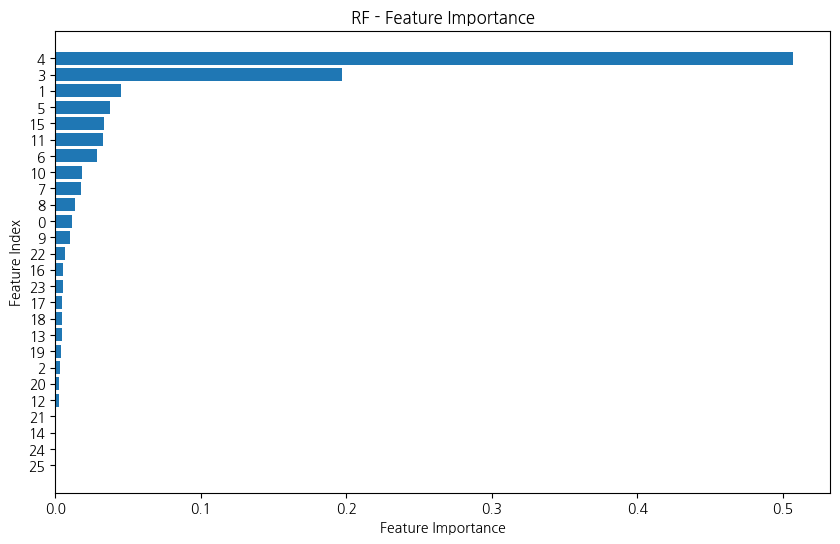

In [37]:
model_rf00 = RandomForestClassifier()

X_features = ['GENDER', 'AGE_GROUP', 'CT_PY_CYCLE_CD', 'CT_PY_PD', 'mean_AMT',
              'GBN_CD_1', 'GBN_CD_2', 'GBN_CD_3', 'GBN_CD_4', '보험종류_1', '보험종류_2',
              '보험종류_3', '보험종류_4', '보험종류_5', '보험종류_6', '보험종류_7', '보험종류_8', '보험종류_9',
              '보험상태_1', '보험상태_2', '보험상태_3', '보험상태_4', '납입주기_1', '납입주기_2', '납입주기_3',
              '납입주기_99']

x = fin_0_0[X_features]
y = fin_0_0['코사인군집']

model_rf00.fit(x, y)

# 특성 중요도 추출
feature_importance = model_rf00.feature_importances_
sorted_idx = np.argsort(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(range(x.shape[1]))[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('RF - Feature Importance')
plt.show()

## 다중 로지스틱회귀

### (1) 분리X

In [38]:
X = fin_0_0[['mean_AMT', 'CT_PY_PD']]
y = fin_0_0['코사인군집']

logi0 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logi0.fit(X, y)

acc_X = logi0.score(X, y)

# 학습된 모델의 계수 확인
lor_coef = logi0.coef_[0]
lor_intercept = logi0.intercept_

# 변수 지정
w1_lor = lor_coef[0].round(2)
w2_lor = lor_coef[1].round(2)
bias_lor = lor_intercept[0].round(2)

print(w1_lor, w2_lor, bias_lor)
print("mean_AMT *", w1_lor, "+", "CT_PY_PD *", w2_lor, "+", bias_lor)
print("정확도:", acc_X)

2.5 -2.01 -0.32
mean_AMT * 2.5 + CT_PY_PD * -2.01 + -0.32
정확도: 0.9906155120066243


C:\Users\LOVE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### (2) AGE_GROUP도 포함

In [40]:
X = fin_0_0[['mean_AMT', 'CT_PY_PD', 'AGE_GROUP']]
y = fin_0_0['코사인군집']

logi0 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logi0.fit(X, y)

acc_X = logi0.score(X, y)

# 학습된 모델의 계수 확인
lor_coef = logi0.coef_[0]
lor_intercept = logi0.intercept_

# 변수 지정
w1_lor = lor_coef[0].round(2)
w2_lor = lor_coef[1].round(2)
w3_lor = lor_coef[2].round(2)
bias_lor = lor_intercept[0].round(2)

print(w1_lor, w2_lor, w2_lor, bias_lor)
print("mean_AMT *", w1_lor, "+", "CT_PY_PD *", w2_lor, "+", "AGE_GROUP *", w3_lor, "+", bias_lor)
print("정확도:", acc_X)

2.39 -1.72 -1.72 -0.47
mean_AMT * 2.39 + CT_PY_PD * -1.72 + AGE_GROUP * -0.24 + -0.47
정확도: 0.9944797129450731


C:\Users\LOVE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 정리

1. 손해보험

- 분리X (0.9655) : mean_AMT * 1.51 + CT_PY_PD * -1.3 + -5.18

- AGE_GROUP도 포함 (0.9695) : mean_AMT * 1.57 + CT_PY_PD * -1.91 + AGE_GROUP * -0.77 + -1.16

</br>

2. 생명보험

- 분리X (0.9706) : mean_AMT * 1.45 + CT_PY_PD * -3.14 + -8.23

- AGE_GROUP도 포함 (0.9862) : mean_AMT * 1.78 + CT_PY_PD * -3.85 + AGE_GROUP * -1.42 + -2.02

</br>

3. 신협

- 분리X (0.9906) : mean_AMT * 2.5 + CT_PY_PD * -2.01 + -0.32

- AGE_GROUP도 포함 (0.9944) : mean_AMT * 2.39 + CT_PY_PD * -1.72 + AGE_GROUP * -0.24 + -0.47